#Problem Statement

Dataset contains 1251 CT scans that are positive for SARS-CoV-2 infection (COVID-19) and 1229 CT scans for patients non-infected by SARS-CoV-2, 2480 CT scans in total. These data have been collected from real patients in hospitals from Sao Paulo, Brazil. The aim is to identify if a person is infected by SARS-CoV-2 through the analysis of his/her CT scans.

In [ ]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import os
import cv2

from tqdm import tqdm
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model,Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.optimizers.legacy import Adamax
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from skimage import io

from keras import Input
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

# Data Mining

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_cov=pathlib.Path('/content/drive/MyDrive/Capstone_project/COVID')
data_non_cov=pathlib.Path('/content/drive/MyDrive/Capstone_project/non-COVID')

In [ ]:
print("No. of images which are showing covid: ",len(list(data_cov.glob('*png')))) #.glob() is used to find files, here it is giving the number of .png files
print("No. of images which are normal: ",len(list(data_non_cov.glob('*png'))))

No. of images which are showing covid:  1251
No. of images which are normal:  1229


In [ ]:
#no. of covid and non covid images are approximately same

In [ ]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content/drive/MyDrive/Capstone_project'
train_dir = os.path.join(data_dir)
#it is used to join more than one path together

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type']) #created a pandas dataframe, with new columns as disease id and disease type
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (215).png,0,COVID
1,COVID/Covid (124).png,0,COVID
2,COVID/Covid (26).png,0,COVID
3,COVID/Covid (187).png,0,COVID
4,COVID/Covid (203).png,0,COVID


In [ ]:
train

,File,DiseaseID,Disease Type
0,COVID/Covid (215).png,0,COVID
1,COVID/Covid (124).png,0,COVID
2,COVID/Covid (26).png,0,COVID
3,COVID/Covid (187).png,0,COVID
4,COVID/Covid (203).png,0,COVID
...,...,...,...
2476,non-COVID/Non-Covid (1132).png,1,non-COVID
2477,non-COVID/Non-Covid (1061).png,1,non-COVID
2478,non-COVID/Non-Covid (1174).png,1,non-COVID
2479,non-COVID/Non-Covid (1022).png,1,non-COVID


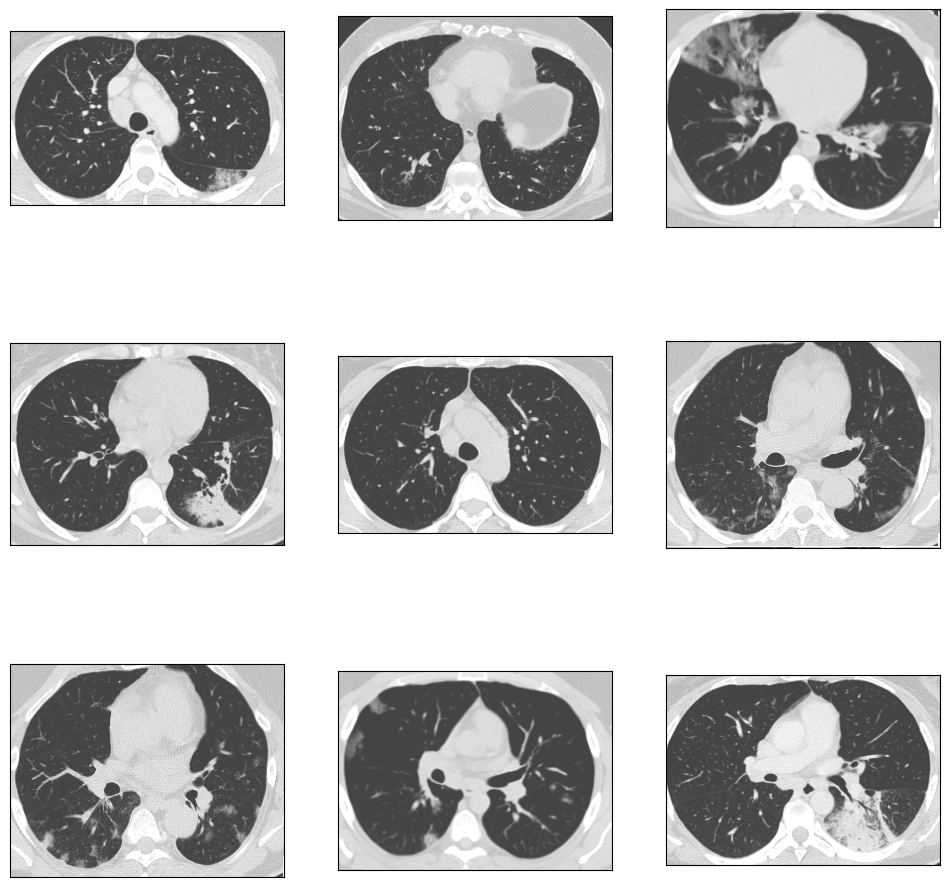

In [ ]:
#displaying some of images of covid training data set
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
plot_defects('COVID', 3, 3)

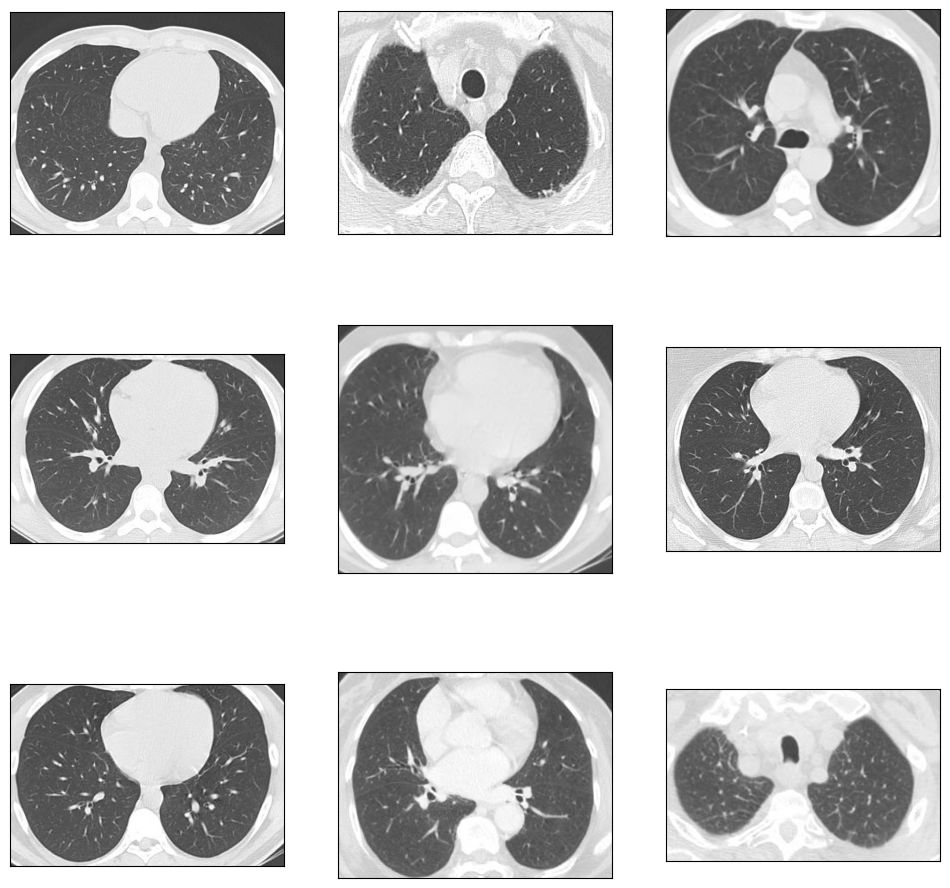

In [ ]:
#displaying some of images of non-covid training data set
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
plot_defects('non-COVID', 3, 3)


In [ ]:
#Resizing images
#The images are in different sizes so need to fix size

IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)

2481it [05:34,  7.42it/s]

(2481, 64, 64, 3)


In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)
Y_train.shape

(2481, 2)

# Splitting and Creating Model

In [ ]:
Batch_Size=65
#splitting the data for training and validation
X_train,X_val,Y_train,Y_val=train_test_split(X_Train,Y_train,test_size=0.2,random_state=42)

In [ ]:
X_train.shape

(1984, 64, 64, 3)

In [ ]:
X_val.shape

(497, 64, 64, 3)

In [ ]:
Y_train.shape

(1984, 2)

In [ ]:
Y_val.shape

(497, 2)

In [ ]:
Epochs=500
size=64

In [ ]:
#Creating the model
def build_resnet50():
    resnet50 = ResNet50(weights='imagenet', include_top=False)

    input = Input(shape=(size,size,3))
    x = Conv2D(3, (3, 3), padding='same')(input)

    x = resnet50(x)

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(2,activation = 'softmax', name='root')(x)


    # model
    model = Model(input,output)
    optimizer = Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
#Data Augmentation
model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_learning_rate=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360, #Degree range for rotations
                        width_shift_range=0.2, #horizontal shifts
                        height_shift_range=0.2, #vertical shifts
                        zoom_range=0.2, #Range for zoom
                        horizontal_flip=True, #flip inputs horizontally
                        vertical_flip=True) #flip inputs vertically

datagen.fit(X_train)

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                               

In [ ]:
#Early Stopping
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [ ]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=Batch_Size),
               steps_per_epoch=X_train.shape[0] // Batch_Size,
               epochs=Epochs,
               verbose=1,
               callbacks=[annealer, checkpoint, early_stopping],
               validation_data=(X_val, Y_val))


Epoch 1/500
30/30 [==============================] - ETA: 0s - loss: 1.1628 - accuracy: 0.5883
Epoch 1: val_loss improved from inf to 1.44837, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 28s 335ms/step - loss: 1.1628 - accuracy: 0.5883 - val_loss: 1.4484 - val_accuracy: 0.5191 - lr: 0.0020
Epoch 2/500
30/30 [==============================] - ETA: 0s - loss: 0.8072 - accuracy: 0.6535
Epoch 2: val_loss improved from 1.44837 to 0.74601, saving model to model.h5
30/30 [==============================] - 5s 162ms/step - loss: 0.8072 - accuracy: 0.6535 - val_loss: 0.7460 - val_accuracy: 0.4809 - lr: 0.0020
Epoch 3/500
30/30 [==============================] - ETA: 0s - loss: 0.6303 - accuracy: 0.7322
Epoch 3: val_loss did not improve from 0.74601
30/30 [==============================] - 4s 139ms/step - loss: 0.6303 - accuracy: 0.7322 - val_loss: 1.0493 - val_accuracy: 0.5191 - lr: 0.0020
Epoch 4/500
30/30 [==============================] - ETA: 0s - loss: 0.5748 - accuracy: 0.7655
Epoch 4: val_loss did not improve from 0.74601
30/30 [==============================] - 4s 122ms/step - loss: 0.5748 - accuracy: 0.7655 - val_loss: 0.7976 - v

#Model Prediction

In [ ]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

16/16 [==============================] - 1s 19ms/step


1/1 [==============================] - 0s 393ms/step
[9.9996769e-01 3.2299224e-05]


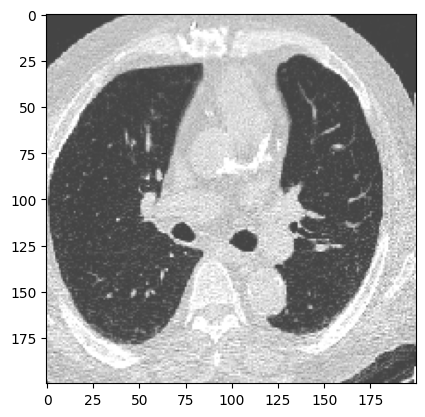

In [ ]:
from skimage import io
from tensorflow.keras.preprocessing import image
img = image.load_img('/content/drive/MyDrive/Capstone_project/COVID/Covid (150).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/content/drive/MyDrive/Capstone_project/COVID/Covid (150).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)

#Multiple Performance Metrics

In [ ]:
confusion_matrix(Y_true, Y_pred)


array([[217,  22],
       [ 42, 216]])

In [ ]:
accuracy_score(Y_true, Y_pred)


0.8712273641851107

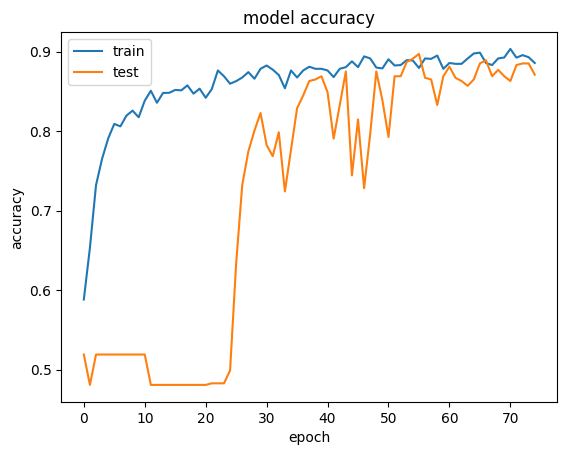

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

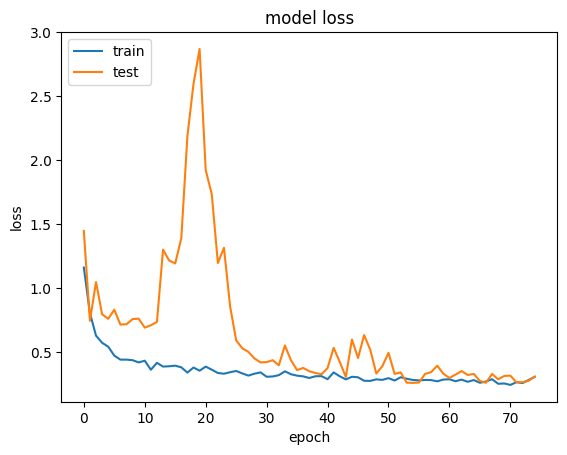

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
print(classification_report(Y_true, Y_pred, target_names=disease_class))

              precision    recall  f1-score   support

    Covid-19       0.84      0.91      0.87       239
Non Covid-19       0.91      0.84      0.87       258

    accuracy                           0.87       497
   macro avg       0.87      0.87      0.87       497
weighted avg       0.87      0.87      0.87       497

